### This Dev notebook builds simple XGB model to predict baby weight

### Outline:
1. Ingest data using BigQuery API.
2. Clean the data.
3. Build model.

In [1]:
project_name = 'My First Project'
project_id = 'quantum-keep-360100'
regionn = 'us-central1'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import os
import shap

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from google.cloud import bigquery, storage
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 50)

# xgb.__version__
os.chdir('/home/jupyter/projects_gcp')

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
time0 = time.time()

query="""
SELECT
  weight_pounds,
  is_male,
  mother_age,
  mother_married,
  plurality,
  gestation_weeks,
  cigarette_use,
  alcohol_use,
  father_age, 
  year,
  month
FROM
  publicdata.samples.natality
WHERE year > 2000
LIMIT 100000
"""
df = bigquery.Client().query(query).to_dataframe()
display(df.shape, df.head())

(100000, 11)

,weight_pounds,is_male,mother_age,mother_married,plurality,gestation_weeks,cigarette_use,alcohol_use,father_age,year,month
0,4.850170,True,30,True,2,35.0,True,True,53,2005,2
1,5.125748,True,38,True,2,39.0,False,False,46,2005,3
2,6.106805,False,18,False,1,38.0,None,None,17,2005,10
3,7.561856,False,25,True,1,41.0,False,False,53,2005,6
4,8.170331,True,40,True,1,NaN,None,None,62,2005,1


,weight_pounds,mother_age,plurality,gestation_weeks,father_age,year,month
count,99902.000000,100000.000000,100000.000000,99536.000000,100000.000000,100000.000000,100000.000000
mean,7.201256,27.396180,1.035430,38.544185,40.350540,2006.160340,6.569850
std,1.312647,6.143375,0.193998,2.555308,24.820578,0.938904,3.423142
min,0.524700,12.000000,1.000000,17.000000,13.000000,2005.000000,1.000000
25%,6.558752,23.000000,1.000000,38.000000,26.000000,2005.000000,4.000000
50%,7.308324,27.000000,1.000000,39.000000,32.000000,2006.000000,7.000000
75%,8.000575,32.000000,1.000000,40.000000,39.000000,2007.000000,10.000000
max,17.749417,50.000000,4.000000,47.000000,99.000000,2008.000000,12.000000


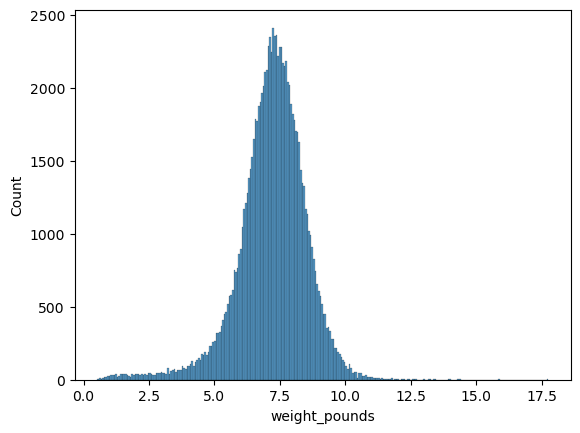

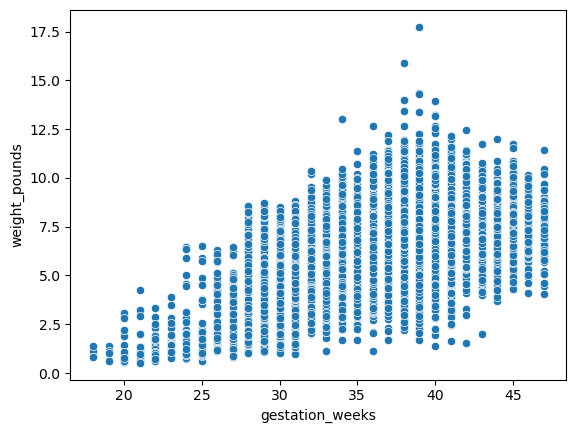

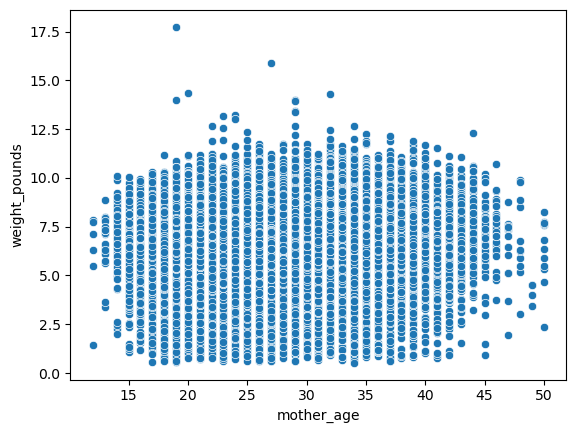

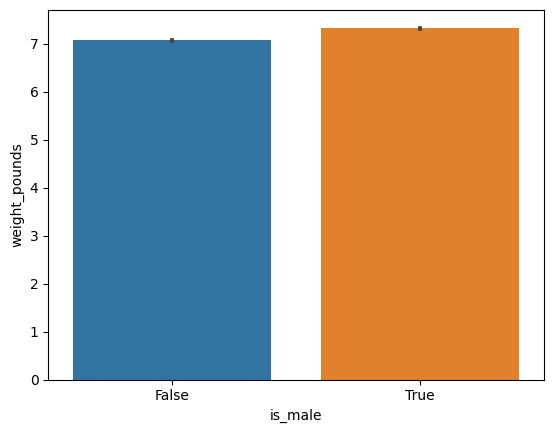

In [4]:
display(df.describe())

sns.histplot(x='weight_pounds', data=df)
plt.show()

sns.scatterplot(x='gestation_weeks', y='weight_pounds', data=df)
plt.show()

sns.scatterplot(x='mother_age', y='weight_pounds', data=df)
plt.show()

sns.barplot(x='is_male', y='weight_pounds', data=df)
plt.show()

In [5]:
cat_f = ['is_male', 'mother_married', 'cigarette_use', 'alcohol_use']
num_f = [col for col in df.columns if (col not in cat_f) and (col != 'weight_pounds')]

features_missing_fill = ['cigarette_use', 'alcohol_use']
for col in features_missing_fill:
    df[col] = df[col].fillna(value = 'MISSING')
    df[col] = df[col].replace({True: 'TRUE', False: 'FALSE'})

df = df.dropna()
df = shuffle(df)

In [6]:
labels = df['weight_pounds']
data = df.drop(columns=['weight_pounds'])
x, y = data,labels
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

display(X_train.shape, X_train.head(), X_test.shape, y_train.shape)

(79564, 10)

,is_male,mother_age,mother_married,plurality,gestation_weeks,cigarette_use,alcohol_use,father_age,year,month
9763,True,21,False,1,40.0,MISSING,MISSING,22,2005,3
85476,True,39,False,1,40.0,TRUE,TRUE,45,2007,3
55316,True,32,True,1,28.0,MISSING,MISSING,32,2007,2
40453,True,31,True,1,38.0,FALSE,FALSE,29,2007,9
79533,True,38,True,3,34.0,FALSE,FALSE,40,2005,12


(19891, 10)

(79564,)

In [7]:
feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_f),
    ], remainder = 'passthrough')

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train

,cat__is_male_True,cat__mother_married_True,cat__cigarette_use_FALSE,cat__cigarette_use_MISSING,cat__cigarette_use_TRUE,cat__alcohol_use_FALSE,cat__alcohol_use_MISSING,cat__alcohol_use_TRUE,remainder__mother_age,remainder__plurality,remainder__gestation_weeks,remainder__father_age,remainder__year,remainder__month
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,21.0,1.0,40.0,22.0,2005.0,3.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,39.0,1.0,40.0,45.0,2007.0,3.0
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,32.0,1.0,28.0,32.0,2007.0,2.0
3,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,31.0,1.0,38.0,29.0,2007.0,9.0
4,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,38.0,3.0,34.0,40.0,2005.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79559,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,31.0,1.0,38.0,35.0,2006.0,9.0
79560,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,21.0,1.0,40.0,99.0,2006.0,3.0
79561,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,28.0,1.0,40.0,27.0,2007.0,9.0
79562,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,22.0,1.0,41.0,99.0,2005.0,11.0


In [8]:
time1 = time.time()
xgbb = XGBRegressor(tree_method = 'gpu_hist',
                    n_estimators = 200,
                    max_depth = 5,
                    eta = 0.1,
                    subsample = 0.8,
                    colsample_bytree = 0.6)

xgbb.fit(X_train, y_train)
print(time.time()-time1)

2.7567968368530273


In [9]:
y_pred = xgbb.predict(X_test)
    
print('train rmse: ', np.sqrt(mean_squared_error(y_train, xgbb.predict(X_train))))
print('test rmse: ', np.sqrt(mean_squared_error(y_test, xgbb.predict(X_test))))
print('total time: ', time.time() - time0)

train rmse:  0.9979824896426256
test rmse:  1.0088672505917797
total time:  6.923435926437378


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


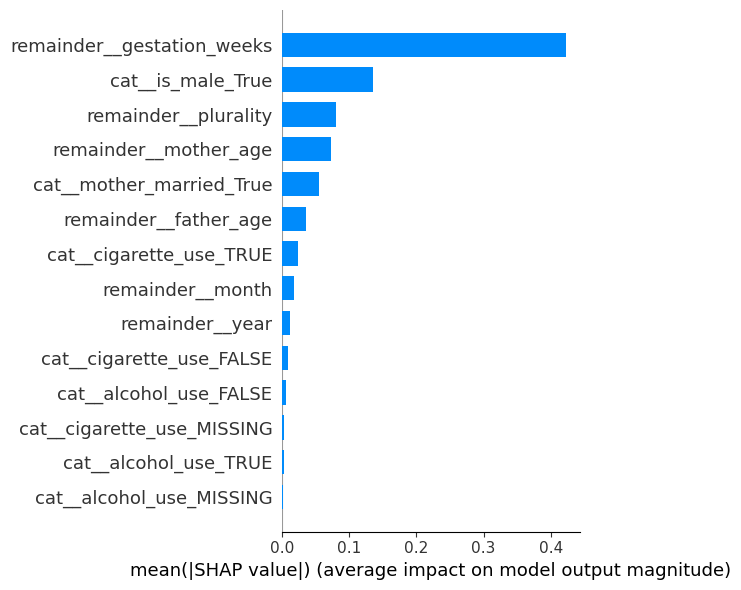

In [ ]:
explainerxgbc = shap.TreeExplainer(xgbb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(6,6), max_display=20)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(6,6), max_display=20)